<a href="https://colab.research.google.com/github/Unrickyelenting/CSRNet-pytorch/blob/master/STNNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the pre-trained model

In [ ]:
pre_train='/content/_model_best.pth.tar'
print("=> loading checkpoint '{}'".format(pre_train))
checkpoint = torch.load(pre_train)
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
my_models = model.state_dict()
pre_models = list(checkpoint['state_dict'].items())
preweight_dict = {}
for i in range(len(pre_models)):
  prelayer_name, pre_weights = pre_models[i]
  preweight_dict[prelayer_name] = pre_weights
  for layer_name, value in my_models.items():
    if 'module.'+layer_name in preweight_dict.keys() or layer_name in preweight_dict.keys():
      try:
        my_models[layer_name] = preweight_dict['module.'+layer_name]
      except:
        my_models[layer_name] = preweight_dict[layer_name]
model.load_state_dict(my_models)
print("=> loaded checkpoint '{}' (epoch {})".format(pre_train, checkpoint['epoch']))


=> loading checkpoint '/content/_model_best.pth.tar'


NameError: ignored

In [ ]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import cv2
import pdb
import scipy.io as io
from torchvision import transforms
import shutil

def load_data(img_path,train):
    #parse annotation of DroneCrowd

    img = Image.open(img_path).convert('RGB')

    gt_path = img_path.replace('.jpg', '.h5').replace('images', 'ground_truth')
    gt_file = h5py.File(gt_path, "r")
    den = np.asarray(gt_file['density'])


    # crop the images and preprocessing them. Randomly choose the patches.
    if train:
      crop_factor = 0.5
      crop_size = (int(img.size[0]*crop_factor),int(img.size[1]*crop_factor))
      if random.randint(0,9) < 5:
        dx = int(random.randint(0,1)*img.size[0]*1./2)
        dy = int(random.randint(0,1)*img.size[1]*1./2)
      else:
        dx = int(random.random()*img.size[0]*1./2)
        dy = int(random.random()*img.size[1]*1./2)

    
      img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
      den = den[int(dy):int(crop_size[1]+dy),int(dx):int(crop_size[0]+dx)]

      #resize the density map to meet the output of the different layer.
      den1 = cv2.resize(den,(int(den.shape[1]/2),int(den.shape[0]/2)),interpolation = cv2.INTER_CUBIC)*4
      den2 = cv2.resize(den,(int(den.shape[1]/4),int(den.shape[0]/4)),interpolation = cv2.INTER_CUBIC)*16
      den3 = cv2.resize(den,(int(den.shape[1]/8),int(den.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
      
      return img, den1, den2, den3

    else:
      
      #validation set preprocessing method. Splite the whole image into four patches. Each patch
      #is 1/4 of original image. Generate the density map for each patches.

      dens,den1,den2,den3=[],[],[],[]
      crop_factor = 0.5
      crop_size = (int(img.size[0]*crop_factor),int(img.size[1]*crop_factor))

      img1 = img.crop((0,0,crop_size[0]+0,crop_size[1]+0))
      img2 = img.crop((int(crop_size[0]),0,crop_size[0]*2,crop_size[1]+0))
      img3 = img.crop((0,int(crop_size[1]),crop_size[0],crop_size[1]*2))
      img4 = img.crop((int(crop_size[0]),int(crop_size[1]),crop_size[0]*2,crop_size[1]*2))


      dens.append(den[0:int(crop_size[1]+0),0:int(crop_size[0]+0)])
      dens.append(den[0:int(crop_size[1]),int(crop_size[0]):int(2*crop_size[0])])
      dens.append(den[int(crop_size[1]):int(2*crop_size[1]),0:int(crop_size[0])])
      dens.append(den[int(crop_size[1]):int(2*crop_size[1]),int(crop_size[0]):int(2*crop_size[0])])
      
      #dens[i]: i is the patches ID which is 0,1,2,3

      for i in range(4):
        # generate the density map for each patches.
        den1.append(cv2.resize(dens[i],(int(den.shape[1]/2),int(den.shape[0]/2)),interpolation = cv2.INTER_CUBIC)*4)
        den2.append(cv2.resize(dens[i],(int(den.shape[1]/4),int(den.shape[0]/4)),interpolation = cv2.INTER_CUBIC)*16)
        den3.append(cv2.resize(dens[i],(int(den.shape[1]/8),int(den.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64)

      # Here img1-img4 is the 4 pathces of the whole image. den1,den2,den3 are the lists. denX(X=1,2,3) is the layers ID and
      # the index in each list is the patches number.For example, den1[0] is the density map from the last layer of the first patches.
      return img1, img2, img3, img4, den1, den2, den3


In [ ]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

import torchvision.transforms.functional as F

class listDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, batch_size=1, num_workers=4):
        if train:
            root = root *4 #because we split the image into 4 patches. 
        random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers

    def __len__(self):
        return self.nSamples
    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        img_path = self.lines[index]
        if self.train:
          img, dengt1, dengt2, dengt3= load_data(img_path,self.train)
          if self.transform is not None:
            img = self.transform(img)
          return img, dengt1, dengt2, dengt3
        else:
          imgs1, imgs2, imgs3, imgs4, dengt1, dengt2, dengt3 = load_data(img_path, self.train)
          # Image preprocessing
          if self.transform is not None:
              imgs1 = self.transform(imgs1)
              imgs2 = self.transform(imgs2)
              imgs3 = self.transform(imgs3)
              imgs4 = self.transform(imgs4)
          return imgs1, imgs2, imgs3, imgs4, dengt1, dengt2, dengt3


In [ ]:
import torch.nn as nn
import torch
from torchvision import models
import numpy as np
import random
import torch.nn.functional as F
import torch.nn.init as init
import math
from matplotlib import pyplot as plt

##############################VGG16 Backbone#######################################
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.backbone1 = make_layers([64, 64, 'M', 128, 128])
        self.backbone2 = make_layers(['M', 256, 256, 256], in_channels=128)
        self.backbone3 = make_layers(['M', 512, 512, 512], in_channels=256)

    def forward(self, x):
        x1 = self.backbone1(x)
        x2 = self.backbone2(x1)
        x3 = self.backbone3(x2)

        return x1, x2, x3

def make_layers(cfg, in_channels=3, batch_norm=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

##############################Space-Time Neighbor-Aware Network####################
class STNNet(nn.Module):
    def __init__(self, use_loc=False, use_trk=False):
        super(STNNet, self).__init__()
        self.loc = use_loc
        self.trk = use_trk
        # backbone
        self.backbone = BaseNet()
        self.relu = nn.ReLU()

        # multi-scale combination
        self.deconv1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1, dilation=2)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1, dilation=2)

        self.conv1 = nn.Conv2d(512, 256, 1)
        self.conv2 = nn.Conv2d(256, 256, 3, padding=1, dilation=1)
        self.conv3 = nn.Conv2d(256, 128, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1, dilation=1)

        # # attention layers
        # self.s_weight1 = SpatialWeightLayer()
        # self.s_weight2 = SpatialWeightLayer()
        # self.s_weight3 = SpatialWeightLayer()

        # density output layers
        self.den_output_layer1 = nn.Conv2d(128, 1, kernel_size=1)
        self.den_output_layer2 = nn.Conv2d(256, 1, kernel_size=1)
        self.den_output_layer3 = nn.Conv2d(512, 1, kernel_size=1)

        # load weights of the backbone network
        mod = models.vgg16(pretrained = True)
        self._initialize_weights()
        my_models = self.backbone.state_dict()
        pre_models = list(mod.state_dict().items())
        count = 0
        for layer_name, value in my_models.items():
            prelayer_name, pre_weights = pre_models[count]
            my_models[layer_name] = pre_weights
            count += 1
        self.backbone.load_state_dict(my_models)

    def forward(self, imgset):
        ## f3 x/8
        f1, f2, f3 = self.backbone(imgset)

        g1_size = (f1.shape[2], f1.shape[3])
        g2_size = (f2.shape[2], f2.shape[3])

        g2 = self.deconv1(f3)
        g2 = self.relu(g2)
        g2 = nn.Upsample(size=g2_size, mode='bilinear', align_corners=True)(g2) ##cut the edge to fit f2
        g2 = torch.cat((g2, f2), 1)
        g2 = self.conv1(g2)
        g2 = self.relu(g2)
        g2 = self.conv2(g2)
        g2 = self.relu(g2)

        g1 = self.deconv2(g2)
        g1 = self.relu(g1)
        g1 = nn.Upsample(size=g1_size, mode='bilinear', align_corners=True)(g1)
        g1 = torch.cat((g1, f1), 1)
        g1 = self.conv3(g1)
        g1 = self.relu(g1)
        g1 = self.conv4(g1)
        g1 = self.relu(g1)

        # g1 = self.s_weight1(g1)
        # g2 = self.s_weight2(g2)
        # f3 = self.s_weight3(f3)


          # generate density map
        den1 = self.den_output_layer1(g1)  # 1/2*1/2 resolution
        # den2 = self.den_output_layer2(g2)  # 1/4*1/4 resolution
        # den3 = self.den_output_layer3(f3)  # 1/8*1/8 resolution

        #return den1, den2, den3
        return den1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_((m.weight), std=0.01)
                if m.bias is not None:
                    nn.init.constant_((m.bias), 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_((m.weight), std=0.01)
                if m.bias is not None:
                    nn.init.constant_((m.bias), 0)   
#The paper did not put this part in the architecture but it is in the code. It can not shows anything so far
# class SpatialWeightLayer(nn.Module):
#     def __init__(self):
#         super(SpatialWeightLayer, self).__init__()
#         kernel_size = 7
#         self.compress = ChannelPool()
#         self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

#     def forward(self, x):
#         x_compress = self.compress(x)
#         x_out = self.spatial(x_compress)
#         scale = torch.sigmoid(x_out)  # broadcasting
#         return x * scale


# class ChannelPool(nn.Module):
#     def forward(self, x):
#         return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)


# class BasicConv(nn.Module):
#     def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True,
#                  bn=False, bias=False):
#         super(BasicConv, self).__init__()
#         self.out_channels = out_planes
#         self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
#                               dilation=dilation, groups=groups, bias=bias)
#         self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
#         self.relu = nn.ReLU() if relu else None

#     def forward(self, x):
#         x = self.conv(x)
#         if self.bn is not None:
#             x = self.bn(x)
#         if self.relu is not None:
#             x = self.relu(x)
#         return x

Statistical method

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, '_model_best.pth.tar')            


Training and validation

In [ ]:
import sys
import os
import warnings
from matplotlib import cm as CM


import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import math
import argparse
import cv2
import time
import glob
import pdb




best_prec1 = 1e6
best_mte1 = 1e6
lr = 1e-7
start_epoch = 0
epochs = 100
workers = 10
factor = 100.
seed = time.time()
print_freq = 10
batch_size=4
def train(train_clip, model, criterion, optimizer, epoch):
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()

    train_loader = torch.utils.data.DataLoader(
        listDataset(train_clip,
                            shuffle=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225]),
                            ]),
                            train=True,
                            batch_size=batch_size,
                            num_workers=workers), pin_memory=True,
        batch_size=batch_size)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), lr))
    model.train()
    end = time.time()

    for i, (img, dengt1, dengt2, dengt3) in enumerate(train_loader):

        data_time.update(time.time() - end)
        img=img.cuda()
        img=Variable(img)
        #den_g1, den_g2, den_g3 = model(img)
        den_g1=model(img)
        # loss for density
        den_loss1, den_loss2, den_loss3 = 0., 0., 0.

        den1 = Variable(dengt1.type(torch.FloatTensor).unsqueeze(0).cuda())
        # den2 = Variable(dengt2.type(torch.FloatTensor).unsqueeze(0).cuda())
        # den3 = Variable(dengt3.type(torch.FloatTensor).unsqueeze(0).cuda())
        
        # den_loss1 = criterion(den_g1, den1*factor) * 2.0 / float(batch_size) / 3. /factor/10.
        # den_loss2 = criterion(den_g2, den2*factor) * 0.5 / float(batch_size) / 3. /factor/10.
        # den_loss3 = criterion(den_g3, den3*factor) * 0.05 / float(batch_size) / 3. /factor/10.

        den_loss1 = criterion(den_g1, den1)
        # den_loss2 = criterion(den_g2, den2) * 0.5 / float(batch_size) / 3.
        # den_loss3 = criterion(den_g3, den3) * 0.05 / float(batch_size) / 3.        


        # den_loss = den_loss1 + den_loss2 + den_loss3

        losses.update(den_loss1.item(), batch_size)# calculate something
        optimizer.zero_grad()
        den_loss1.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()



        den_loss1 = den_loss1.item()
        # den_loss2 = den_loss2.item()
        # den_loss3 = den_loss3.item()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.2f} ({loss.avg:.2f})\t'
                  'denLoss {den_loss1:.2f}\t'
                  .format(epoch, i, len(train_loader), loss=losses,
                          den_loss1=den_loss1
                          ))
        # if i % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Loss {loss.val:.2f} ({loss.avg:.2f})\t'
        #           'denLoss {den_loss1:.2f}/{den_loss2:.2f}/{den_loss3:.2f}\t'
        #           .format(epoch, i, len(train_loader), loss=losses,
        #                   den_loss1=den_loss1, den_loss2=den_loss2, den_loss3=den_loss3
        #                   ))

def validate(val_clip, model):
    print ('begin test')
    test_loader = torch.utils.data.DataLoader(
          listDataset(val_clip,
                shuffle=False,
                transform=transforms.Compose([
                transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ]),  train=False),
          batch_size=batch_size)    
    print(len(test_loader))
    model.eval()
    
    mae = 0
    
    for i,(imgs1, imgs2, imgs3, imgs4, dengt1, dengt2, dengt3) in enumerate(test_loader):
        with torch.no_grad():
            imgs1 = imgs1.cuda()
            imgs2 = imgs2.cuda()
            imgs3 = imgs3.cuda()
            imgs4 = imgs4.cuda()
            imgs1 = Variable(imgs1)
            imgs2 = Variable(imgs2)
            imgs3 = Variable(imgs3)
            imgs4 = Variable(imgs4)

            den_g11=model(imgs1)
            den_g21=model(imgs2)
            den_g31=model(imgs3)
            den_g41=model(imgs4)
            # den_g11, den_g12, den_g13 = model(imgs1)
            # den_g21, den_g22, den_g23 = model(imgs2)
            # den_g31, den_g32, den_g33 = model(imgs3)
            # den_g41, den_g42, den_g43 = model(imgs4)
            
            #######################################
            #CHOOSE WHICH LAYER TO OUTPUT
            #######################################

            mae += abs(den_g11.data.sum()-dengt1[0].sum().type(torch.FloatTensor).cuda())
            mae += abs(den_g21.data.sum()-dengt1[1].sum().type(torch.FloatTensor).cuda())
            mae += abs(den_g31.data.sum()-dengt1[2].sum().type(torch.FloatTensor).cuda())
            mae += abs(den_g41.data.sum()-dengt1[3].sum().type(torch.FloatTensor).cuda())
        
    mae = mae/len(test_loader)/float(batch_size)/4    
    print(' * MAE {mae:.3f} '
              .format(mae=mae))

    return mae


# prepare the train/val dataset
root = '/content/drive/MyDrive/part_B_final/'

train_root=root+'train_data/images/'
train_list=glob.glob(pathname=train_root+'*.jpg')

test_root=root+'test_data/images/'
test_list=glob.glob(pathname=test_root+'*.jpg')

  # train_clip = []

  # for idx in range(len(train_list)):
  #   if train_step % 1 == 0:
  #     clip, imgs, seqids = [], [], []
  #     for i in range(nframe):
  #       cur_img = train_list[max(0, idx - i)]
  #       seqid = cur_img[-10:-7]
  #       imgs.append(cur_img)
  #       seqids.append(seqid)

  #     for i in range(nframe - 1):
  #       cur_img = imgs[i]
  #       pre_img = imgs[i + 1]
  #       seq_id1 = seqids[i]
  #       seq_id2 = seqids[i + 1]
  #       if i == 0:
  #         if seq_id1 == seq_id2:
  #           clip.append(cur_img)
  #           clip.append(pre_img)
  #         else:
  #           clip.append(cur_img)
  #           clip.append(cur_img)
  #       else:
  #         if seq_id1 == seq_id2:
  #           clip.append(pre_img)
  #         else:
  #           clip.append(cur_img)
  #       train_clip.append(clip[::-1])
  #     train_step += 1


torch.cuda.manual_seed(seed)

model = STNNet().cuda()
    
criterion = nn.MSELoss(reduction='sum').cuda()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(model_parameters, lr=lr, betas=(0.5, 0.999))
# if args.pre_train:
#     if os.path.isfile(args.pre_train):
#         print("=> loading checkpoint '{}'".format(args.pre_train))
#         checkpoint = torch.load(args.pre_train)
#         args.start_epoch = checkpoint['epoch']
#         best_prec1 = checkpoint['best_prec1']
#         my_models = model.state_dict()
#         pre_models = list(checkpoint['state_dict'].items())
#         preweight_dict = {}
#         for i in range(len(pre_models)):
#             prelayer_name, pre_weights = pre_models[i]
#             preweight_dict[prelayer_name] = pre_weights
#         for layer_name, value in my_models.items():
#             if 'module.'+layer_name in preweight_dict.keys() or layer_name in preweight_dict.keys():
#                 try:
#                     my_models[layer_name] = preweight_dict['module.'+layer_name]
#                 except:
#                     my_models[layer_name] = preweight_dict[layer_name]
#         model.load_state_dict(my_models)
#         print("=> loaded checkpoint '{}' (epoch {})".format(args.pre_train, checkpoint['epoch']))
#         else:
#             print("=> no checkpoint found at '{}'".format(args.pre_train))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Training and validation process begin

In [ ]:
pre=None
best_prec1=1000000.0

task_id='The last layer'

for epoch in range(start_epoch, epochs):
    train(train_list, model, criterion, optimizer, epoch)

    prec1 = validate(test_list, model)
    is_best = prec1 <= best_prec1 
    best_prec1 = min(prec1, best_prec1)
    print(' * best MAE {mae:.3f} '.format(mae=best_prec1))

    save_checkpoint({
        'epoch': epoch + 1,
        'arch': pre,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best, task_id)


epoch 0, processed 0 samples, lr 0.0000001000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 4, 192, 256])) that is different to the input size (torch.Size([4, 1, 192, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: [0][0/400]	Loss 6.29 (6.29)	denLoss 6.29	
Epoch: [0][10/400]	Loss 15.00 (8.73)	denLoss 15.00	
Epoch: [0][20/400]	Loss 9.71 (10.90)	denLoss 9.71	
Epoch: [0][30/400]	Loss 6.02 (10.19)	denLoss 6.02	
Epoch: [0][40/400]	Loss 5.18 (10.49)	denLoss 5.18	
Epoch: [0][50/400]	Loss 10.86 (10.57)	denLoss 10.86	
Epoch: [0][60/400]	Loss 17.69 (10.74)	denLoss 17.69	
Epoch: [0][70/400]	Loss 11.62 (10.50)	denLoss 11.62	
Epoch: [0][80/400]	Loss 8.03 (10.27)	denLoss 8.03	
Epoch: [0][90/400]	Loss 9.13 (10.59)	denLoss 9.13	
Epoch: [0][100/400]	Loss 6.44 (10.54)	denLoss 6.44	
Epoch: [0][110/400]	Loss 8.37 (10.31)	denLoss 8.37	
Epoch: [0][120/400]	Loss 10.63 (10.18)	denLoss 10.63	
Epoch: [0][130/400]	Loss 7.59 (10.20)	denLoss 7.59	
Epoch: [0][140/400]	Loss 6.97 (10.36)	denLoss 6.97	
Epoch: [0][150/400]	Loss 8.65 (10.29)	denLoss 8.65	
Epoch: [0][160/400]	Loss 7.33 (10.36)	denLoss 7.33	
Epoch: [0][170/400]	Loss 8.81 (10.29)	denLoss 8.81	
Epoch: [0][180/400]	Loss 7.97 (10.44)	denLoss 7.97	
Epoch: [0][190/

Density map generation

In [ ]:
model.eval()


STNNet(
  (backbone): BaseNet(
    (backbone1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
    )
    (backbone2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

Visualize. But it shows the result that not we expected.

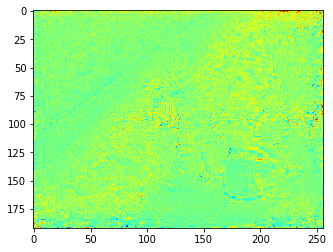

In [ ]:
# Visualization method
img='/content/drive/MyDrive/part_B_final/test_data/images/IMG_2.jpg'
import torchvision.transforms.functional as F
import PIL.Image as Image

img=Image.open(img).convert('RGB')
crop_factor = 0.5
crop_size = (int(img.size[0]*crop_factor),int(img.size[1]*crop_factor))


dx=0
dy=0
    
img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])
# img = 255.0 * F.to_tensor(img)

# img[0,:,:]=img[0,:,:]-92.8207477031
# img[1,:,:]=img[1,:,:]-95.2757037428
# img[2,:,:]=img[2,:,:]-104.877445883
img=transform(img)
img = img.cuda()

output=model(img.unsqueeze(0))
output=output.squeeze(0)
output=output.squeeze(0)
plt.imshow(torch.Tensor.cpu(output).detach().numpy(),cmap=CM.jet)




In [ ]:
output.sum()

tensor(26.7837, device='cuda:0', grad_fn=<SumBackward0>)

Show the input image

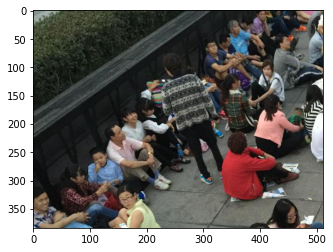

In [ ]:
showimg='/content/drive/MyDrive/part_B_final/test_data/images/IMG_2.jpg'
showimg=Image.open(showimg).convert('RGB')
crop_factor = 0.5
crop_size = (int(showimg.size[0]*crop_factor),int(showimg.size[1]*crop_factor))


dx=0
dy=0
    
showimg = showimg.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))

# showimg = 255.0 * F.to_tensor(showimg)

plt.imshow(showimg)

Ground truth.

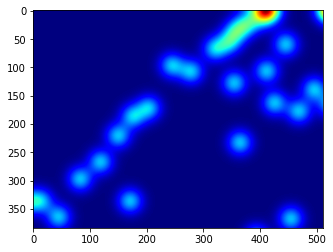

In [ ]:
showimg='/content/drive/MyDrive/part_B_final/test_data/images/IMG_2.jpg'
gt_path = showimg.replace('.jpg', '.h5').replace('images', 'ground_truth')
gt_file = h5py.File(gt_path, "r")
den = np.asarray(gt_file['density'])
den_gt=den[int(dy):int(crop_size[1]+dy),int(dx):int(crop_size[0]+dx)]
plt.imshow(den_gt,cmap=CM.jet)